## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [2]:
import os
import keras

from keras.regularizers import l1, l2, l1_l2
import matplotlib.pyplot as plt
%matplotlib inline

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.9 #佔用 GPU 多少比例的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# l1 = Regularization, L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [6]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 82us/step - loss: 6.0058 - acc: 0.2698 - val_loss: 5.8059 - val_acc: 0.3518
Epoch 2/50
50000/50000 [==============================] - 3s 67us/step - loss: 5.7230 - acc: 0.3651 - val_loss: 5.6462 - val_acc: 0.3829
Epoch 3/50
50000/50000 [==============================] - 3s 63us/step - loss: 5.5766 - acc: 0.3946 - val_loss: 5.5207 - val_acc: 0.4049
Epoch 4/50
50000/50000 [==============================] - 3s 64us/step - loss: 5.4584 - acc: 0.4136 - val_loss: 5.4034 - val_acc: 0.4202
Epoch 5/50
50000/50000 [==============================] - 3s 65us/step - loss: 5.3480 - acc: 0.4303 - val_loss: 5.3082 - val_acc: 0.4325
Epoch 6/50
50000/50000 [==============================] - 3s 64us/step - loss: 5.2464 - acc: 0.4434 - val_loss: 5.2110 - val_acc: 0.4421
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 5.1509 - acc: 0.4550 - val_loss: 5.1260 - val_acc

50000/50000 [==============================] - 3s 62us/step - loss: 1.8033 - acc: 0.3655 - val_loss: 1.7555 - val_acc: 0.3813
Epoch 3/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.7159 - acc: 0.3964 - val_loss: 1.6832 - val_acc: 0.4091
Epoch 4/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6550 - acc: 0.4200 - val_loss: 1.6633 - val_acc: 0.4116
Epoch 5/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6086 - acc: 0.4360 - val_loss: 1.6048 - val_acc: 0.4307
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.5705 - acc: 0.4511 - val_loss: 1.5733 - val_acc: 0.4445
Epoch 7/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.5386 - acc: 0.4612 - val_loss: 1.5832 - val_acc: 0.4359
Epoch 8/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.5103 - acc: 0.4710 - val_loss: 1.5339 - val_acc: 0.4570
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 63us/step - loss: 1.7286 - acc: 0.3938 - val_loss: 1.7026 - val_acc: 0.3974
Epoch 4/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6717 - acc: 0.4128 - val_loss: 1.6648 - val_acc: 0.4153
Epoch 5/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6256 - acc: 0.4306 - val_loss: 1.6199 - val_acc: 0.4315
Epoch 6/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5888 - acc: 0.4427 - val_loss: 1.5788 - val_acc: 0.4469
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5536 - acc: 0.4559 - val_loss: 1.5550 - val_acc: 0.4546
Epoch 8/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5234 - acc: 0.4689 - val_loss: 1.5316 - val_acc: 0.4578
Epoch 9/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.4970 - acc: 0.4764 - val_loss: 1.5120 - val_acc: 0.4674
Epoch 10/50
50000/50000 [===========================

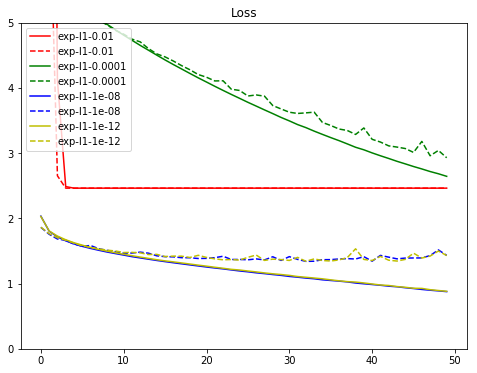

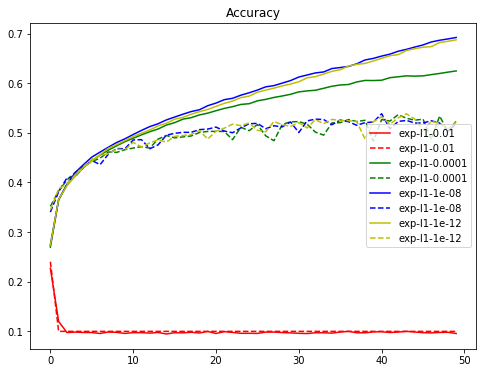

In [9]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# l1_l2 = Regularization, L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [16]:
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [18]:
results = {}
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 88us/step - loss: 18.8198 - acc: 0.2813 - val_loss: 17.3632 - val_acc: 0.3424
Epoch 2/50
50000/50000 [==============================] - 3s 61us/step - loss: 16.1462 - acc: 0.3621 - val_loss: 14.9792 - val_acc: 0.3746
Epoch 3/50
50000/50000 [==============================] - 3s 62us/step - loss: 13.9584 - acc: 0.3821 - val_loss: 12.9756 - val_acc: 0.3933
Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 12.1099 - acc: 0.3973 - val_loss: 11.2740 - val_acc: 0.4018
Epoch 5/50
50000/50000 [==============================] - 3s 62us/step - loss: 10.5383 - acc: 0.4049 - val_loss: 9.8239 - val_acc: 0.4122
Epoch 6/50
50000/50000 [==============================] - 3s 61us/step - loss: 9.2015 - acc: 0.4121 - val_loss: 8.5956 - val_acc: 0.4163
Epoch 7/50
50000/50000 [==============================] - 3s 61us/step - loss: 8.0626 - acc: 0.4162 - val_loss: 7.5436 

50000/50000 [==============================] - 3s 64us/step - loss: 13.0275 - acc: 0.3548 - val_loss: 12.1357 - val_acc: 0.3724
Epoch 3/50
50000/50000 [==============================] - 3s 64us/step - loss: 11.3534 - acc: 0.3783 - val_loss: 10.5996 - val_acc: 0.3908
Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 9.9403 - acc: 0.3935 - val_loss: 9.3011 - val_acc: 0.4005
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 8.7409 - acc: 0.4038 - val_loss: 8.1930 - val_acc: 0.4101
Epoch 6/50
50000/50000 [==============================] - 3s 63us/step - loss: 7.7190 - acc: 0.4112 - val_loss: 7.2526 - val_acc: 0.4167
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 6.8468 - acc: 0.4172 - val_loss: 6.4523 - val_acc: 0.4212
Epoch 8/50
50000/50000 [==============================] - 3s 64us/step - loss: 6.1038 - acc: 0.4218 - val_loss: 5.7679 - val_acc: 0.4248
Epoch 9/50
50000/50000 [========================

50000/50000 [==============================] - 3s 63us/step - loss: 11.3346 - acc: 0.3835 - val_loss: 10.5820 - val_acc: 0.3942
Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 9.9253 - acc: 0.3953 - val_loss: 9.2845 - val_acc: 0.4016
Epoch 5/50
50000/50000 [==============================] - 3s 64us/step - loss: 8.7269 - acc: 0.4038 - val_loss: 8.1917 - val_acc: 0.4075
Epoch 6/50
50000/50000 [==============================] - 3s 64us/step - loss: 7.7047 - acc: 0.4121 - val_loss: 7.2502 - val_acc: 0.4144
Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 6.8338 - acc: 0.4216 - val_loss: 6.4413 - val_acc: 0.4203
Epoch 8/50
50000/50000 [==============================] - 3s 64us/step - loss: 6.0897 - acc: 0.4260 - val_loss: 5.7571 - val_acc: 0.4279
Epoch 9/50
50000/50000 [==============================] - 3s 66us/step - loss: 5.4549 - acc: 0.4298 - val_loss: 5.1711 - val_acc: 0.4313
Epoch 10/50
50000/50000 [=========================

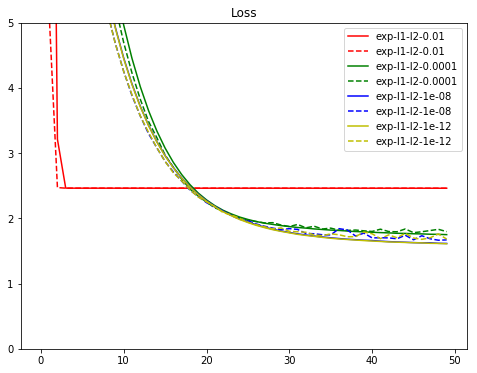

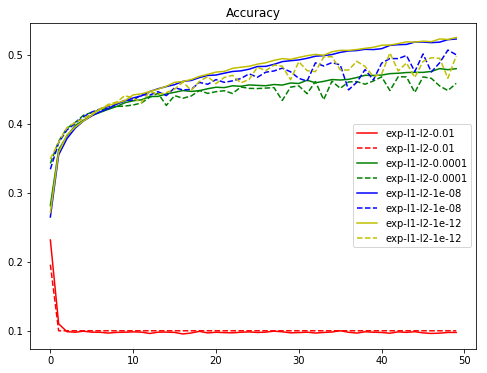

In [19]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()